In [43]:
import os

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import sys
import pandas as pd
#import tensorflow
#import keras
import wordcloud
import nltk
import inspect
import re
import unicodedata

nltk.download('stopwords')

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import RSLPStemmer #Stemmer for portugese words.

from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest
stop = stopwords.words('portuguese')
stop.append('nao') #Stopword already have "Não", just adding this because it's appear on dataframe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d.cadavid141\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
#import missingno as msno
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,roc_curve
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import time
import sys
import math
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import folium
#from folium.plugins import Fullscreen
#import geopandas as gpd
import json
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Defining functions
def PCA_var(varianza,X):
    """
    Function responsible for calculating the number of components to explain the % of variance 
    
    Returns:
        number of components
    """
 
   
    pca = PCA(varianza)
    pca_fit = pca.fit(X)
    features = pca_fit.n_components_
    
    return features
    
    
def PCA_comp(comp,X):
    """
    Function responsible for calculating the explained variance based on a number of components
    
    Returns:
        Explained variance
    """
    
    pca = PCA(n_components=comp)
    pca_fit = pca.fit(X)
    var = np.sum(pca_fit.explained_variance_ratio_)
    
    return var
    
    

def format_spines(ax, right_border=True):
    """
    This function is responsible for format axis from graphs
    
    Input:
        ax: matplotlib axis
        right_border: boolean flag for plot the right border of graphs
    
    Output:
        None
    """    
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def bar_plot(x, y, df, ax, colors='Blues_d', hue=False, value=False):
    """
    This function plots, and customize a bar chart

    Input:
        x: feature to be plotted on x axis
        y: feature to be plotted on y axis
        df: DataFrame object with features used on x and y
        colors: standard palette is "Blues_d"
        hue: separation value, standard is False
        value: flag for defining if the data labels on bars will be the value (True) or percentual (False)
        
    Returns:
        None
    """
    # Counting numerical feature (x or y)
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    
    # Plotting
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Customizing data labels (values of percents)
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom')
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom')
            
def add_series_working_days(series_name, df, date_col1, date_col2):
    """
    This function is used for calculating working days between two dates
    as an additional column on a DataFrame
    
    Input:
        series_names: name of the new series created with working days calculated
        df: DataFrame object with the dates
        date_col1: date column 1
        date_col2: date column 2
        
    Returns:
        df_return: DataFrame with working days columns
    """
    # Creating a list with the difference between dates
    time_list = []
    idx = 0
    second_date_series = df[date_col2].values.astype('datetime64[D]')
    for date in df[date_col1].values.astype('datetime64[D]'):
        second_date = second_date_series[idx]
        try:
            workdays = np.busday_count(date, second_date)
        except:
            workdays = np.NaN
        time_list.append(workdays)
        idx += 1
    
    # Adding column in a DataFrame object
    df_return = df.copy()
    df_return[series_name] = pd.Series(time_list)
    df_return.dropna(inplace=True)
    
    return df_return

def communicate_params(freight, deliv, est):
    """
    Additional function create for helping on graphical exploration (state dashboard)
    
    Input:
        freight: freight value to be plotted as a text
        deliv: delivery time to be plotted as a text
        estimative: differente between delivery time and estimative time to be plotted as a text
    
    Returns:
        None
    """  
    # Comunicando o frete
    axs[0, 0].text(0.10, 0.30, f'R${freight:.2f}', fontsize=45)
    axs[0, 0].text(0.07, 0.12, 'is the mean value of freight paid', fontsize=12)
    axs[0, 0].text(0.25, 0.00, 'for online shopping', fontsize=12)
    axs[0, 0].axis('off')

    # Comunicando tempo médio de entrega
    axs[0, 1].text(0.13, 0.30, f'{deliv:.2f}', fontsize=45)
    axs[0, 1].text(0.62, 0.30, 'working days', fontsize=12)
    axs[0, 1].text(0.07, 0.12, 'is the average delay for delivery', fontsize=12)
    axs[0, 1].text(0.23, 0.00, 'for online shopping', fontsize=12)
    axs[0, 1].axis('off')

    # Comunicando diferença entre tempo de entrega e tempo estimado
    axs[0, 2].text(0.18, 0.30, f'{est:.2f}', fontsize=45)
    axs[0, 2].text(0.58, 0.30, 'working days', fontsize=12)
    axs[0, 2].text(0.07, 0.12, 'is the difference between estimated', fontsize=12)
    axs[0, 2].text(0.23, 0.00, 'date and delivery date', fontsize=12)
    axs[0, 2].axis('off') 
    
def plot_param(df, col, title, xlim, n_row, n_col, y='customer_state', div_xlim=0, 
               one_axis=False, xlabel=[], ylabel='State'):
    """
    This function is used for plotting a comparative study on 5 better and 5 worst according to the topic
    
    Input:
        df: DataFrame object with the data
        col: column to be studied
        title: title
        xlim: xlim
        n_row: line index where the graph will be plotted
        n_col: column index where the graph will be plotted
    """
    # Axis definition
    if one_axis:
        ax_top = axs[n_col]
        ax_last = axs[n_col+1]
    else:
        ax_top = axs[n_row, n_col]
        ax_last = axs[n_row+1, n_col]
    
    # First step: Top 5
    df.sort_values(by=col, ascending=False, inplace=True)
    top5 = df.iloc[:5, :]
    sns.barplot(x=col, y=y, data=top5, ci=None, palette='Blues_d', ax=ax_top)
    format_spines(ax_top, right_border=False)
    ax_top.set_title(title)
    ax_top.set_xlim(0, xlim)
    ax_top.set_xlabel(xlabel)
    if n_col > 0:
        ax_top.set_ylabel('')
    else:
        ax_top.set_ylabel(ylabel)
    
    # Second step: Last 5
    last5 = df.iloc[-5:, :]
    sns.barplot(x=col, y=y, data=last5, ci=None, palette='Blues_d', ax=ax_last)
    format_spines(ax_last, right_border=False)
    ax_last.set_title(title.replace('Highest', 'Lowest'))
    if div_xlim > 0:
        ax_last.set_xlim(0, xlim/div_xlim)
    else:
        ax_last.set_xlim(0, xlim)
    ax_last.set_xlabel(xlabel)
    if n_col > 0:
        ax_last.set_ylabel('')
    else:
        ax_last.set_ylabel(ylabel)
        
def donut_plot(col, ax, df, labels, text='', flag_ruido = 0,
               colors=['navy', 'lightsteelblue', 'lightgreen', 'crimson', '']):
    """
    This function plots a customized donut plot
    
    Input:
        col: coluna a ser analisada e plotada no gráfico de rosca
        ax: matplotlib axis
        df: DataFrame with data
        labels: list of labels to be plotted
        text: text to be plotted on the center of the donut
        flag_ruido: thie parameter indicates the number of labels to be filtered from plot
        colors: list of colors (4 colors from default)
    """
    flag_ruido = flag_ruido * -1
    if flag_ruido < 0:
        sizes = df[col].value_counts().values[:flag_ruido]
        labels = labels[:flag_ruido]
    else:
        sizes = df[col].value_counts().values
    center_circle = plt.Circle((0,0), 0.80, color='white')
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%')
    ax.add_artist(center_circle)
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    
def text_process(c):
    """
    Function responsible for removing punctuation and stopwords from reviews
    
    Input:
        c: customer review
    
    Output:
        reviews without punctuation and stopwords
    """
    # Remove punctuation
    nopunc = [char for char in c if char not in string.punctuation]

    # Join string again
    nopunc = ''.join(nopunc)
    
    # Remove stopwords
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

def stem_processing(c):
    """
    Function repsonsible for apply stemming on reviews
    
    Input:
        c: customer review
        
    Output:
        review after stemming
    """
    
    stemmer = RSLPStemmer()
    return list(map(lambda x: stemmer.stem(x), [word for word in c.split()]))

def create_dataset():
    """
    Function responsible for creating an empty DataFrame object with some of classification metrics
    
    Returns:
        empty DataFrame object
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
        
    return model_performance

def model_analysis(model, X, y, X_test, y_test, df_performance, cv=5, train=True):
    """
    Function responsible for evaluate a classification model and save the results on a DataFrame object
    
    Input:
        model: model to be used on evaluation
        X, y, X_test, y_test: train and test data (with target labels)
        df_performance: empty DataFrame (generated by create_dataset() function)
        cv: cross validation k folds

    Returns:
        a DataFrame object with classification metrics selected
    """
    # Accuracy, precision, recall and f1_score on training set using cv
    t0_cv = time.time()
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    # Time spent on cross_validation prediction
    t1_cv = time.time()
    delta_time_cv = t1_cv-t0_cv
    
    # Evaluation using the test set
    t0_test = time.time()
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    y_scores_test = model.predict_proba(X_test)[:, 1]
    # Time spent on test prediction
    t1_test = time.time()
    delta_time_test = t1_test-t0_test

    # Saving on dataframe
    performances = {}
    performances['acc'] = round(acc, 4)
    performances['prec'] = round(prec, 4)
    performances['rec'] = round(rec, 4)
    performances['f1'] = round(f1, 4)
    performances['total_time'] = round(delta_time_cv, 3)        
    df_performance = df_performance.append(performances, ignore_index=True)
    
    test_performances = {}
    test_performances['acc'] = round(acc_test, 4)
    test_performances['prec'] = round(prec_test, 4)
    test_performances['rec'] = round(rec_test, 4)
    test_performances['f1'] = round(f1_test, 4)
    test_performances['total_time'] = round(delta_time_test, 3)        
    df_performance = df_performance.append(test_performances, ignore_index=True)
    
    model_name = model.__class__.__name__
    df_performance.index = [model_name+' cv', model_name+' test']
    
    return df_performance

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots a customized confusion matrix
    
    Input:
        cm: confusion matrix generated from sklearn's method confusion_matrix(set, predictions)
        classes: target labels to be plotted
        title: title
        cmap: matrix color
    Output:
        None
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Plot configuration
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def style_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'grey',
        'weight': 1.5,
        'dashArray': '5, 5'
    }

def highlight_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }

def plot_sentimento(model, frase):
    """
    This function receives a text example and uses a classification model to predict
    the sentiment label and communicate the result in a graphic plot
    
    Input:
        model: classification model
        frase: pre processed text
    
    Output:
        result plotted on matplotlib
    """
    # Predicting
    pred = model.predict(frase)
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        proba = 100 * round(model.predict_proba(frase)[0][1], 4)
        color = 'seagreen'
    else:
        text = 'Negative'
        proba = 100 * round(model.predict_proba(frase)[0][0], 4)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment', fontsize=14)
    plt.show()

In [5]:
os.getcwd()

'C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\03_Codigos'

In [6]:
#os.chdir("/Users/danielacadavid/Documents/Universidad/Maestria/201920/00_Bases/brazilian-ecommerce/")
os.chdir("C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\00_Bases\\brazilian-ecommerce\\")
os.getcwd()

'C:\\Users\\d.cadavid141\\Documents\\Coisas Daniela\\201920\\201920\\00_Bases\\brazilian-ecommerce'

In [7]:
orders=pd.read_csv('data_tratada_v_nao.csv')

In [8]:
####### ACA SE CREA EL BOW
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(orders.review_comment_message).toarray()
#y_count = orders.review_score

# Creating the class label
#bin_edges = [0, 2, 5]
#bin_names = ['0', '1']
#reviews['class'] = pd.cut(reviews['review_score'], bins=bin_edges, labels=bin_names)
#X = reviews['review_comment_message']
#y = reviews['class'].values
#y = y.astype(int)
#X_tfidf = X_tfidf.todense()

In [9]:
#orders.head(5)

In [10]:
X_tfidf.shape

(41753, 10176)

In [11]:
# Creating the class label
bin_edges = [0, 2, 5]
bin_names = ['0', '1']
orders['class'] = pd.cut(orders['review_score'] , bins=bin_edges, labels=bin_names)
#orders = orders.iloc[:, np.r_[0, 1, 3, 4, 2, 5,6]

In [12]:
#orders.head(5)

In [13]:
y = orders['class'].values
Y_tf = y.astype(int)
Y_tf

array([1, 1, 1, ..., 1, 0, 0])

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y_tf, test_size = 3/10, random_state = 9)

In [15]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X_train)
X_std_test = StandardScaler().fit_transform(X_test)

## ACA HAGO EL TESTE DE PCA Y EL GRAFICO

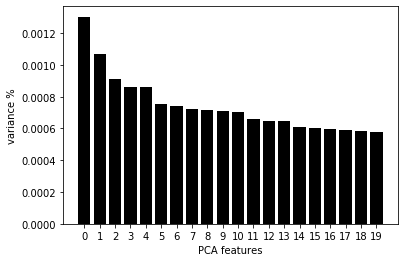

In [16]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [17]:

# Ao ter tao pouca varianza explicada com 20 componentes se analiza se continuar usando: 
# Sao necessarios muitos componentes para explicar el 95% de la varianza 

#var=0.95
#comp=20
#print('Precisa de: '+f'{PCA_var(var,X_std)}'+' para obter '+f'{var*100}'+'% de varianza')
#print('Obteria: '+f'{PCA_comp(comp,X_std)*100}'+'% de varianza explicada com '+f'{comp}'+' componentes')
# Make an instance of the Model
#pca = PCA(.7)

In [18]:
#Transformo mi base a componentes principales
# Make an instance of the Model
pca = PCA()

In [18]:
#Fit PCA on training set. Note: you are fitting PCA on the training set only.
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
#Apply the mapping (transform) to both the training set and the test set.
X_train_pca = pca.transform(X_std)
X_test_pca = pca.transform(X_std_test)

In [20]:
X_std.shape

(29227, 10176)

In [21]:
X_train_pca.shape

(29227, 10176)

In [22]:
pca.fit(X_std)
variance = pca.explained_variance_ratio_ #calculate variance ratios

In [23]:
var=np.cumsum(variance)

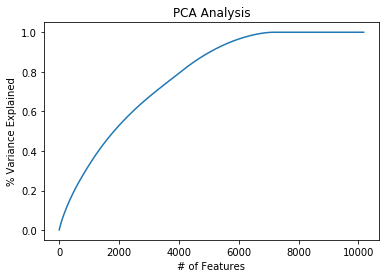

In [24]:
#%matplotlib notebook
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
#plt.ylim(10176,100.5)
#plt.style.context('seaborn-whitegrid')
plt.plot(var)

## TRANSFORMACIÓN DE MI BASE A PCA 

In [16]:
pca = PCA(0.7)

In [17]:
#Fit PCA on training set. Note: you are fitting PCA on the training set only.
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=0.7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
#Apply the mapping (transform) to both the training set and the test set.
X_train_pca = pca.transform(X_std)
X_test_pca = pca.transform(X_std_test)

In [19]:
X_train_pca.shape

(29227, 3216)

In [20]:
X_train_mod=pd.DataFrame(X_train_pca)
#X_train_mod.columns = cols

X_test_mod=pd.DataFrame(X_test_pca)
#X_test_mod.columns = cols

In [21]:
len(X_train_mod.columns)

3216

In [22]:
X_train_n=X_train_mod
X_test_n=X_test_mod

## RANDOM FOREST

In [31]:
from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

In [32]:
auc_f=0
idx = 0
dif=0.000005
array_rf= np.empty((3216, 3))

for var in tqdm(range(len(X_train_n.columns))):
    
    if var==0:
        X_train_t=X_train_n[X_train_n.columns[0:1]]
        X_test_t =X_test_n[X_test_n.columns[0:1]]
        clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
        #gb_clf = GradientBoostingClassifier(learning_rate=0.5,max_depth=5, random_state=9)
        clf.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, clf.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, clf.predict(X_train_t))
        vect_random=[1,rf_roc_auc,rf_roc_auc_train]
        array_rf = vect_random
    else:
        X_train_t=X_train_n[X_train_n.columns[0:var+1]]
        X_test_t =X_test_n[X_test_n.columns[0:var+1]]
        clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
        #gb_clf = GradientBoostingClassifier(learning_rate=0.5,max_depth=5, random_state=9)
        clf.fit(X_train_t, y_train)
        rf_roc_auc=roc_auc_score(y_test, clf.predict(X_test_t))
        rf_roc_auc_train=roc_auc_score(y_train, clf.predict(X_train_t))
        vect_random=[var+1,rf_roc_auc,rf_roc_auc_train]
        array_rf = np.vstack((array_rf,vect_random))
        
    if rf_roc_auc>auc_f:
        auc_f=rf_roc_auc
        idx=var+1
    
    else:
        auc_f=auc_f
        idx=idx
        #break    # break here
        
    df_return = idx
print("Se necesitan: ", idx," variables")
print("Para tener: {0:.3f}".format(auc_f*100)," de AUC")

100%|██████████| 3216/3216 [76:35:54<00:00, 85.74s/it]    


Se necesitan:  20  variables
Para tener: 82.864  de AUC


In [33]:
cols_array=['NumVar','AUC','AUC_train']
salvar_rf=pd.DataFrame(array_rf)
#cols_array=['NumVar','AUC']
salvar_rf.columns=cols_array
salvar_rf.to_csv('array_rf_pca.csv')

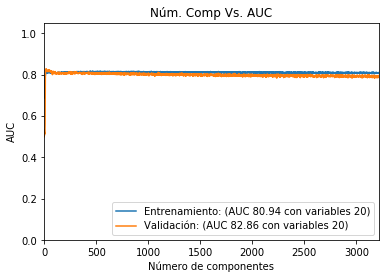

In [42]:
#%matplotlib notebook
plt.figure()
plt.plot(array_rf[:,0], array_rf[:,2],label='Entrenamiento: (AUC {0:.2f}'.format(array_rf[df_return-1,2]*100)+' con variables {0:.0f}'.format(array_rf[df_return-1,0])+')')
plt.plot(array_rf[:,0], array_rf[:,1],label='Validación: (AUC {0:.2f}'.format(array_rf[df_return-1,1]*100)+' con variables {0:.0f}'.format(array_rf[df_return-1,0])+')')
#plt.plot([0, 1586.0], [0, 1],'r--')
plt.xlim([0.0, 3216.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Número de componentes')
plt.ylabel('AUC')
plt.title('Núm. Comp Vs. AUC')
plt.legend(loc="lower right")
plt.savefig('RF_PCA_Vars')
plt.show()

In [39]:
X_train_t=X_train_n[X_train_n.columns[0:df_return]]
X_test_t =X_test_n[X_test_n.columns[0:df_return]]
clf = RandomForestClassifier(n_estimators=100,criterion="gini",max_depth=5, random_state=9)
clf.fit(X_train_t, y_train)
lr_roc_auc=roc_auc_score(y_test, clf.predict(X_test_t))

In [40]:
lr_roc_auc_train=roc_auc_score(y_train, clf.predict(X_train_t))
lr_roc_auc_train*100

80.9416640954918

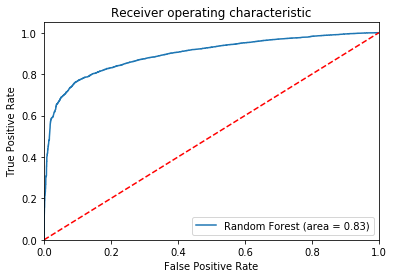

In [41]:
# ROC Logistic Reg
#%matplotlib notebook
#rf_roc_auc = roc_auc_score(y_test, logr.predict(X_test_t))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_t)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_PCA_ROC')
plt.show()